# Model Stacking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [2]:
clean_train = "../../data/clean/clean_train.csv"
clean_val = "../../data/clean/clean_val.csv"
clean_test = "../../data/clean/clean_test.csv"
train_subsam = "../../data/clean/train_subsam.csv"
train_smote = "../../data/clean/train_smote.csv"
stack_model = "../../models/meta_model.joblib"

rnd_stack = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Model Training

### Model Tuning

**Base Models and Meta-Model**

In [ ]:
base_models = [
    ("lr", LogisticRegression(C=1, penalty="l2", random_state=rnd_stack, max_iter=1000)),
    ("knn", KNeighborsClassifier(n_neighbors=10, weights="uniform", metric="manhattan")),
    ("dtc", DecisionTreeClassifier(criterion="entropy", max_depth=20, random_state=rnd_stack)),
    ("rfc", RandomForestClassifier(criterion="entropy", max_depth=20, random_state=rnd_stack)),
    ("xgb", XGBClassifier(learning_rate=0.2, max_depth=10, random_state=rnd_stack))
]

In [ ]:
# stacked_model = StackingClassifier(estimators=base_models, final_estimator=XGBClassifier())

In [ ]:
# param_grid = {"rfc__n_estimators": [100, 200],
#               "xgb__max_depth": [10, 20],
#               "final_estimator__max_depth": [10, 20, 30],
#               "final_estimator__random_state": [rnd_stack]}

In [ ]:
# grid_sm = GridSearchCV(stacked_model, param_grid, cv=10, scoring="accuracy")
# grid_sm.fit(X_train, y_train)

# params = grid_sm.best_params_
# print("Better Parameters:", params)

In [ ]:
meta_model = XGBClassifier(learning_rate=0.1, max_depth=10, random_state=rnd_stack)

In [ ]:
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=44)),
                               ('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=10)),
                               ('dtc',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       random_state=44)),
                               ('rfc',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       random_state=44)),
                               ('xgb',
                                XGBClassifier(base_score=...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=10, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=44, ...))

In [ ]:
acc_val = stacked_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9548


**Customize Base Models and Meta-Model**

In [6]:
base_models = [
    ("lr", LogisticRegression(C=1, penalty="l2", random_state=rnd_stack, max_iter=1000)),
    ("knn", KNeighborsClassifier(n_neighbors=10, weights="uniform", metric="manhattan")),
    ("dtc", DecisionTreeClassifier(criterion="entropy", max_depth=20, random_state=rnd_stack)),
    ("rfc", RandomForestClassifier(criterion="entropy", max_depth=20, random_state=rnd_stack)),
    ("xgb", XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_stack))
]

In [7]:
scaler = StandardScaler()

X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()
X_under_std = df_under.copy()
X_smote_std = df_smote.copy()

X_train_std[num_cols] = scaler.fit_transform(X_train_std[num_cols])
X_val_std[num_cols] = scaler.fit_transform(X_val_std[num_cols])
X_test_std[num_cols] = scaler.fit_transform(X_test_std[num_cols])
X_under_std[num_cols] = scaler.fit_transform(X_under_std[num_cols])
X_smote_std[num_cols] = scaler.fit_transform(X_smote_std[num_cols])

In [8]:
scaler = MinMaxScaler()

X_train_nrm = X_train.copy()
X_val_nrm = X_val.copy()
X_test_nrm = X_test.copy()
X_under_nrm = df_under.copy()
X_smote_nrm = df_smote.copy()

X_train_nrm[num_cols] = scaler.fit_transform(X_train_nrm[num_cols])
X_val_nrm[num_cols] = scaler.fit_transform(X_val_nrm[num_cols])
X_test_nrm[num_cols] = scaler.fit_transform(X_test_nrm[num_cols])
X_under_nrm[num_cols] = scaler.fit_transform(X_under_nrm[num_cols])
X_smote_nrm[num_cols] = scaler.fit_transform(X_smote_nrm[num_cols])

In [9]:
lr_cols = list(X_train.columns)
knn_cols = ["State","DifState","Sector","AppYear","Term","Secured","Urban","RevLine","LowDoc","SecuredSBA"]
dtc_cols = ["State","BankState","DifState","AppYear","Term","NoEmp","GrDisburs","ApprovSBA","SecuredSBA"]
rfc_cols = ["State","BankState","Sector","AppYear","Term","GrDisburs","GrApprov","ApprovSBA","SecuredSBA"]
xgb_cols = list(X_train.columns)

In [10]:
lr_train = base_models[0][1].fit(X_train_std[lr_cols], y_train).predict(X_train_std[lr_cols])
knn_train = base_models[1][1].fit(X_train_nrm[knn_cols], y_train).predict(X_train_nrm[knn_cols])
dtc_train = base_models[2][1].fit(X_train[dtc_cols], y_train).predict(X_train[dtc_cols])
rfc_train = base_models[3][1].fit(X_train[rfc_cols], y_train).predict(X_train[rfc_cols])
xgb_train = base_models[4][1].fit(X_train[xgb_cols], y_train).predict(X_train[xgb_cols])

lr_val = base_models[0][1].predict(X_val_std[lr_cols])
knn_val = base_models[1][1].predict(X_val_nrm[knn_cols])
dtc_val = base_models[2][1].predict(X_val[dtc_cols])
rfc_val = base_models[3][1].predict(X_val[rfc_cols])
xgb_val = base_models[4][1].predict(X_val[xgb_cols])

lr_test = base_models[0][1].predict(X_test_std[lr_cols])
knn_test = base_models[1][1].predict(X_test_nrm[knn_cols])
dtc_test = base_models[2][1].predict(X_test[dtc_cols])
rfc_test = base_models[3][1].predict(X_test[rfc_cols])
xgb_test = base_models[4][1].predict(X_test[xgb_cols])

lr_under = base_models[0][1].predict(X_under_std[lr_cols])
knn_under = base_models[1][1].predict(X_under_nrm[knn_cols])
dtc_under = base_models[2][1].predict(X_under[dtc_cols])
rfc_under = base_models[3][1].predict(X_under[rfc_cols])
xgb_under = base_models[4][1].predict(X_under[xgb_cols])

lr_smote = base_models[0][1].predict(X_smote_std[lr_cols])
knn_smote = base_models[1][1].predict(X_smote_nrm[knn_cols])
dtc_smote = base_models[2][1].predict(X_smote[dtc_cols])
rfc_smote = base_models[3][1].predict(X_smote[rfc_cols])
xgb_smote = base_models[4][1].predict(X_smote[xgb_cols])

In [11]:
X_train_base = pd.concat([X_train,
                        #   pd.DataFrame({"LR": lr_train}),
                        #   pd.DataFrame({"KNN": knn_train}),
                          pd.DataFrame({"DTC": dtc_train}),
                          pd.DataFrame({"RFC": rfc_train}),
                        #   pd.DataFrame({"XGB": xgb_train})
                        ], axis=1)

X_val_base = pd.concat([X_val,
                        # pd.DataFrame({"LR": lr_val}),
                        # pd.DataFrame({"KNN": knn_val}),
                        pd.DataFrame({"DTC": dtc_val}),
                        pd.DataFrame({"RFC": rfc_val}),
                        # pd.DataFrame({"XGB": xgb_val})
                        ], axis=1)

X_test_base = pd.concat([X_test,
                        #  pd.DataFrame({"LR": lr_test}),
                        #  pd.DataFrame({"KNN": knn_test}),
                         pd.DataFrame({"DTC": dtc_test}),
                         pd.DataFrame({"RFC": rfc_test}),
                        #  pd.DataFrame({"XGB": xgb_test})
                        ], axis=1)

X_under_base = pd.concat([X_under,
                        #   pd.DataFrame({"LR": lr_under}),
                        #   pd.DataFrame({"KNN": knn_under}),
                          pd.DataFrame({"DTC": dtc_under}),
                          pd.DataFrame({"RFC": rfc_under}),
                        #   pd.DataFrame({"XGB": xgb_under})
                        ], axis=1)

X_smote_base = pd.concat([X_smote,
                        #   pd.DataFrame({"LR": lr_smote}),
                        #   pd.DataFrame({"KNN": knn_smote}),
                          pd.DataFrame({"DTC": dtc_smote}),
                          pd.DataFrame({"RFC": rfc_smote}),
                        #   pd.DataFrame({"XGB": xgb_smote})
                        ], axis=1)

In [12]:
X_train_base.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,DTC,RFC
124572,9,1,1,19,39,4,98,23,0,0,1,0,0,0,445000,445000,333750,75,1,1
578762,47,52,0,20,30,8,84,2,0,1,0,0,0,1,49000,49000,44100,90,0,0
114929,10,12,0,20,22,12,140,4,0,0,0,0,0,0,102000,102000,102000,100,0,0


In [ ]:
param_grid = {"learning_rate": [0.1, 0.2, 0.3],
              "max_depth": [10, 20, 30],
              "n_estimators": [100, 200, 300],
              "random_state": [rnd_stack]}

In [ ]:
grid_xgb = GridSearchCV(XGBClassifier(), param_grid, cv=10)
grid_xgb.fit(X_train, y_train)

params = grid_xgb.best_params_
print("Better Parameters:", params)

Better Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'random_state': 44}


In [13]:
meta_model = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_stack)

meta_model.fit(X_train_base, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [14]:
acc_val = meta_model.score(X_val_base, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9433


In [15]:
y_pred = meta_model.predict(X_val_base)

print("F1-Score Val:", round(f1_score(y_val, y_pred, average="macro"), 4))

F1-Score Val: 0.9015


### Feature Importance

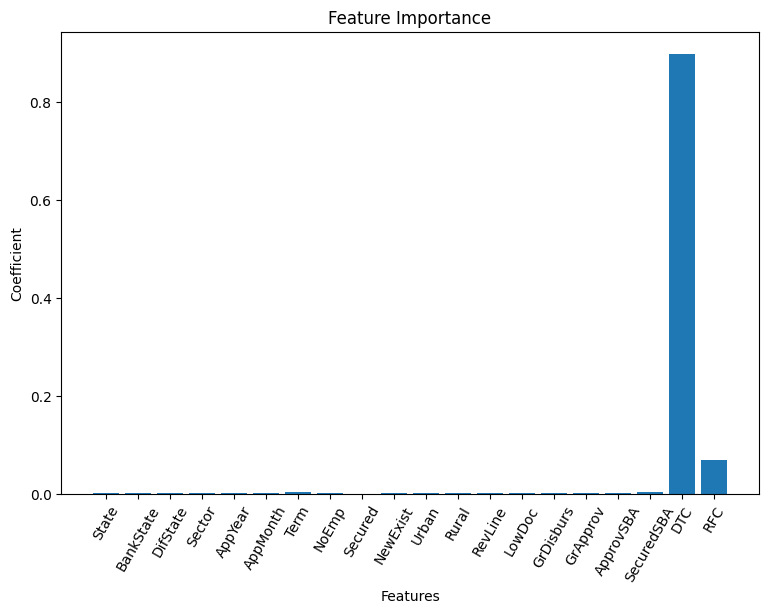

In [16]:
X_cols = X_train_base.columns
coef_dtc = meta_model.feature_importances_

plt.figure(figsize=(9, 6))
plt.bar(X_cols, coef_dtc)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [17]:
meta_ref = XGBClassifier(learning_rate=0.1, max_depth=10, random_state=rnd_stack)

rfe_meta = RFE(meta_ref)
rfe_meta.fit(X_train_base, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=0.1, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=10, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=None,
                            num_parallel_tree=None, random_state=44, ...))

In [18]:
rfe_mat = list(zip(X_train_base.columns.values.tolist(), rfe_meta.support_, rfe_meta.ranking_))
rfe_mat

[('State', False, 2),
 ('BankState', True, 1),
 ('DifState', True, 1),
 ('Sector', False, 7),
 ('AppYear', True, 1),
 ('AppMonth', False, 10),
 ('Term', True, 1),
 ('NoEmp', False, 9),
 ('Secured', False, 11),
 ('NewExist', False, 6),
 ('Urban', False, 3),
 ('Rural', True, 1),
 ('RevLine', True, 1),
 ('LowDoc', False, 8),
 ('GrDisburs', False, 5),
 ('GrApprov', False, 4),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', True, 1),
 ('DTC', True, 1),
 ('RFC', True, 1)]

In [19]:
sel_cols = [tupla[1] for tupla in rfe_mat]
rfe_cols = X_train_base.loc[:, sel_cols].columns
rfe_cols

Index(['BankState', 'DifState', 'AppYear', 'Term', 'Rural', 'RevLine',
       'ApprovSBA', 'SecuredSBA', 'DTC', 'RFC'],
      dtype='object')

In [20]:
meta_ref.fit(X_train_base[rfe_cols], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [21]:
y_ref = meta_ref.predict(X_val_base[rfe_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.9419


In [22]:
y_pred = meta_ref.predict(X_val_base[rfe_cols])

print("F1-Score Val:", round(f1_score(y_val, y_pred, average="macro"), 4))

F1-Score Val: 0.8993


### Balanced Datasets

**Subsample Dataset**

In [23]:
meta_under = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_stack)

meta_under.fit(X_under_base, y_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [24]:
acc_under = meta_under.score(X_val_base, y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.9277


In [25]:
y_pred = meta_under.predict(X_val_base)

print("F1-Score Val:", round(f1_score(y_val, y_pred, average="macro"), 4))

F1-Score Val: 0.8859


**SMOTE Dataset**

In [26]:
meta_smote = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rnd_stack)

meta_smote.fit(X_smote_base, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)

In [27]:
acc_smote = meta_smote.score(X_val_base, y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.9283


In [28]:
y_pred = meta_smote.predict(X_val_base)

print("F1-Score Val:", round(f1_score(y_val, y_pred, average="macro"), 4))

F1-Score Val: 0.8833


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [29]:
results = cross_val_score(meta_model, X_test_base, y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.95405204 0.95085502 0.95033457 0.95182156 0.94892193 0.9532342
 0.95301115 0.94988848 0.95256153 0.95546137]
Accuracy Test (mean +/- desv): 0.9520 +/- 0.0019


In [30]:
y_cv_test = cross_val_predict(meta_model, X_test_base, y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.952


**Model Scores**

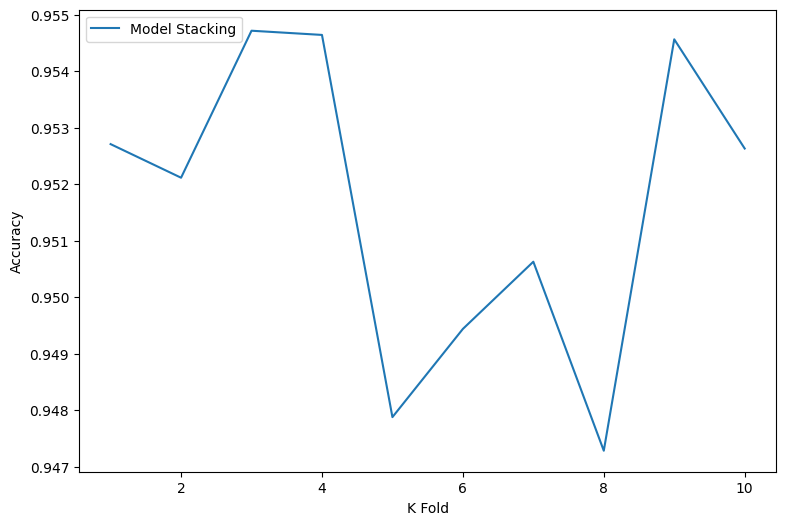

In [31]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(meta_model, X_test_base, y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="Model Stacking")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [32]:
y_pred = meta_model.predict(X_test_base)

In [33]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9434
Precisión:    0.9073
Sensibilidad: 0.8966
F1-score:     0.9019


In [34]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9623    0.9692    0.9657    110629
           1     0.8524    0.8241    0.8380     23869

    accuracy                         0.9434    134498
   macro avg     0.9073    0.8966    0.9019    134498
weighted avg     0.9428    0.9434    0.9431    134498



**Confusion Matrix**

In [35]:
cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_xgb)

[[0.79720145 0.02533123]
 [0.0312198  0.14624753]]


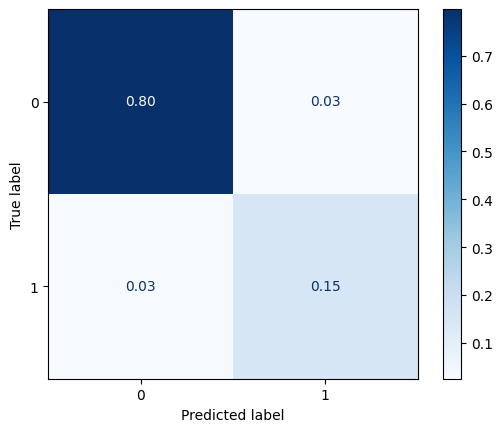

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                              display_labels=meta_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

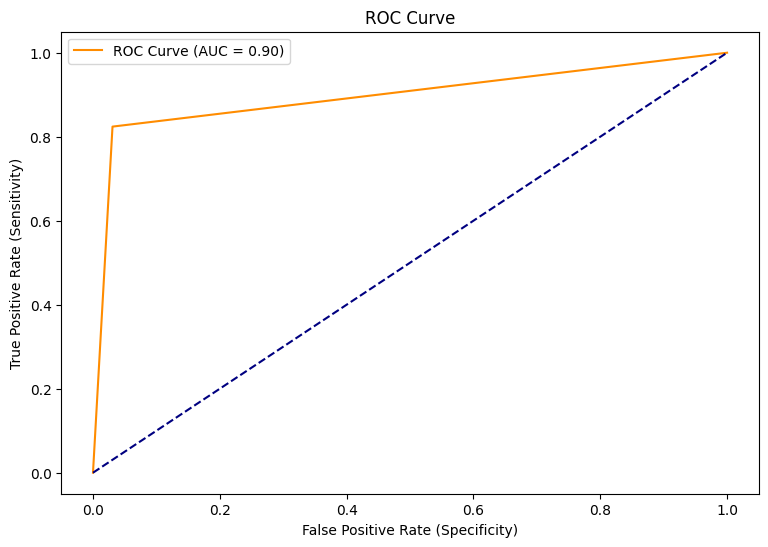

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [38]:
class MetaModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dtc = DecisionTreeClassifier(criterion="entropy",
                                          max_depth=20,
                                          random_state=rnd_stack)
        self.dtc_cols = ["State","BankState","DifState","AppYear","Term",
                         "NoEmp","GrDisburs","ApprovSBA","SecuredSBA"]

        self.rfc =  RandomForestClassifier(criterion="entropy",
                                           max_depth=20,
                                           random_state=rnd_stack)
        self.rfc_cols = ["State","BankState","Sector","AppYear","Term",
                         "GrDisburs","GrApprov","ApprovSBA","SecuredSBA"]

        self.meta = XGBClassifier(learning_rate=0.1,
                                  max_depth=10,
                                  n_estimators=300,
                                  random_state=rnd_stack)

    def fit(self, X, y):
        self.dtc.fit(X[self.dtc_cols], y)
        y_dtc = self.dtc.predict(X[self.dtc_cols])

        self.rfc.fit(X[self.rfc_cols], y)
        y_rfc = self.rfc.predict(X[self.rfc_cols])

        X_ = np.column_stack((X, y_dtc, y_rfc))
        self.meta.fit(X_, y)
        return self

    def predict(self, X, y=None):
        y_dtc = self.dtc.predict(X[self.dtc_cols])
        y_rfc = self.rfc.predict(X[self.rfc_cols])

        X_ = np.column_stack((X, y_dtc, y_rfc))
        y_pred = self.meta.predict(X_)
        return y_pred

In [39]:
meta_pipe = Pipeline([("meta_model", MetaModel())])

### Test the Pipeline

**Internal Partition**

In [40]:
meta_pipe.fit(X_train, y_train)
y_pred = meta_pipe.predict(X_val)

In [41]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9433
Precisión:    0.9067
Sensibilidad: 0.8966
F1-score:     0.9015


**External Partition**

In [42]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

In [43]:
meta_pipe.fit(X_train_val, y_train_val)
y_pred = meta_pipe.predict(X_test)

In [44]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9436
Precisión:    0.9085


Sensibilidad: 0.8953
F1-score:     0.9017


**The Best Model**

In [51]:
meta_pipe.fit(X_train_val, y_train_val)
y_pred = meta_pipe.predict(X_test)

In [45]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9436
Precisión:    0.9085
Sensibilidad: 0.8953
F1-score:     0.9017


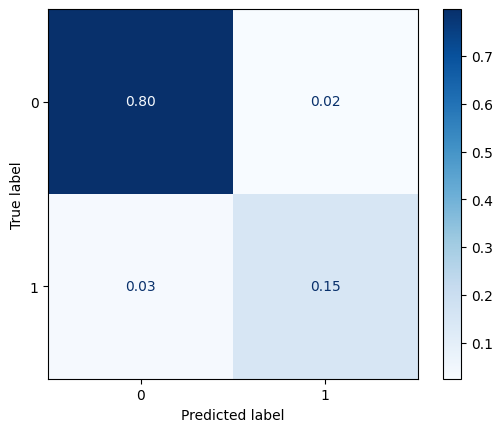

In [46]:
cm_xgb = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                              display_labels=meta_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

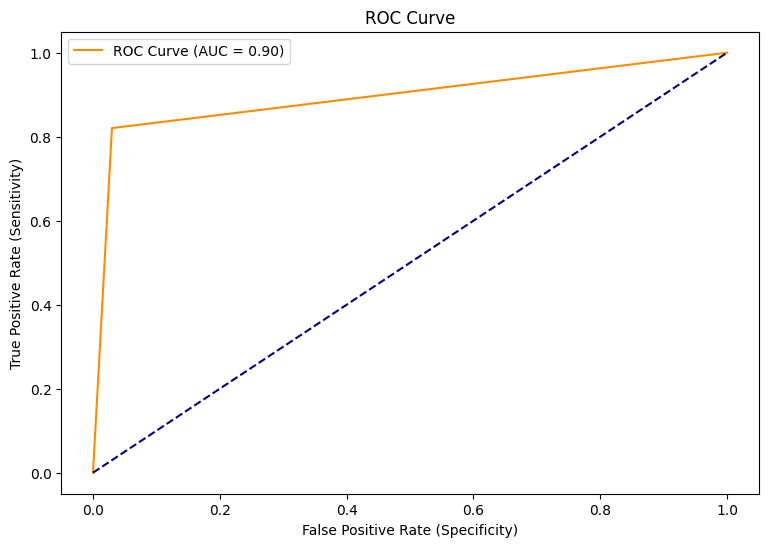

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [ ]:
try:
    joblib.dump(meta_pipe, stack_model)

    meta_model = joblib.load(stack_model)
    print(f"Model stacking loaded...")

except Exception as err:
    print("Error:", str(err))

Model stacking loaded...


In [ ]:
y_pred = meta_model.predict(X_test)
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [ ]:
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
57064,34,37,0,20,33,7,36,9,0,0,0,0,0,0,100000,100000,50000,50,0,0
63823,38,41,0,1,45,3,60,2,0,0,1,0,0,0,36600,36600,18300,50,0,0
113464,4,30,1,10,37,10,84,23,0,0,1,0,1,0,50000,50000,25000,50,0,0
11108,43,47,0,12,26,8,120,50,0,0,0,0,0,0,550000,550000,467500,85,0,0
93172,19,30,1,20,26,4,240,11,1,0,0,0,0,0,512000,512000,435200,85,0,0
114867,18,21,0,20,36,3,120,2,0,1,1,0,0,1,100000,100000,80000,80,0,0
43839,4,5,0,10,38,12,120,25,0,0,1,0,0,0,500000,500000,375000,75,0,0
124733,41,26,1,20,35,4,120,13,0,0,0,0,0,0,262000,262000,196500,75,0,0
37486,34,37,0,10,30,2,84,25,0,1,0,0,0,0,275000,275000,229350,83,0,0
125499,38,9,1,19,42,10,88,1,0,0,1,0,0,0,214400,214400,160800,75,1,0
